In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import pandas
import math

In [ ]:
train_file = "./train.tsv"
test_file = "./test.tsv"

train_data = pandas.read_csv(train_file, delimiter='\t').to_numpy()
train_data2 = np.empty((train_data.shape[0], train_data.shape[1]-2))
train_data2[:, 0:] = train_data[:, 2:]
train_data2[:,0:1] = train_data2[:,0:1] / 4.0   #季節を0～1に正規化
train_data2[:,2:3] = train_data2[:, 2:3] / 6.0 #月を0～1に正規化
train_data2[:,3:4] = train_data2[:, 3:4] / 11.5 #時間を0～1に正規化
train_data2[:,5:6] = train_data2[:,5:6] / 6.0   #曜日を0～1に正規化
train_data2[:,7:8] = train_data2[:,7:8] / 4.0   #天気を0～1に正規化
train_data2 = train_data2#.astype(np.float32)
rnd = np.random.default_rng()
rnd.shuffle(train_data2,axis=0)

test_data = pandas.read_csv(test_file, delimiter='\t').to_numpy()
test_data2 = np.empty((test_data.shape[0], test_data.shape[1]-2))
test_data2[:, 0:] = test_data[:, 2:]
test_data2[:,3:4] = test_data2[:, 3:4] / 12.0 #月を0～1に正規化
test_data2[:,5:6] = test_data2[:,5:6] / 6.0   #曜日を0～1に正規化
test_data2[:,7:8] = test_data2[:,7:8] / 4.0   #天気を0～1に正規化
test_data2 = test_data2.astype(np.float32)

display(train_data2)
display(test_data2)

x = train_data2[:, 12:]
x = x.reshape(x.shape[0], 1)
#print(x)
y = train_data2[:, :12]
y = y.reshape(y.shape[0], y.shape[1],1)
#print(y)
test_y = test_data2.reshape(test_data2.shape[0], test_data2.shape[1], 1)

In [ ]:
osaka_file = "./test_local_osaka3.tsv"
osaka_data = pandas.read_csv(osaka_file, delimiter='\t').to_numpy()
osaka_data2 = np.empty((osaka_data.shape[0], osaka_data.shape[1]-2))
osaka_data2[:, 0:] = osaka_data[:, 2:]
osaka_data2[:,0:1] = osaka_data2[:,0:1] / 4.0   #季節を0～1に正規化
osaka_data2[:,2:3] = osaka_data2[:, 2:3] / 6.0 #月を0～1に正規化
osaka_data2[:,3:4] = osaka_data2[:, 3:4] / 11.5 #時間を0～1に正規化
osaka_data2[:,5:6] = osaka_data2[:,5:6] / 6.0   #曜日を0～1に正規化
osaka_data2[:,7:8] = osaka_data2[:,7:8] / 4.0   #天気を0～1に正規化
osaka_data2 = osaka_data2.astype(np.float32)
osaka_y = osaka_data2.reshape(osaka_data2.shape[0], osaka_data2.shape[1], 1)
display(osaka_data2)

In [ ]:
length_of_sequence = y.shape[1]
#print(length_of_sequence)
in_out_neurons = 1 #入出力ノード数
n_hidden = 500  #隠れ層 -> 数が多い程，学習モデルの複雑さが増加

model = Sequential()
model.add(LSTM(n_hidden, input_shape=(length_of_sequence, in_out_neurons), return_sequences=False))
model.add(Dense(in_out_neurons))
model.add(Activation("linear"))
optimizer = Adam(learning_rate=0.001)
model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
ES = EarlyStopping(mode='auto', patience=20)
model.fit(y, x,
          batch_size=16,
          epochs=512, #100 epochで学習
          validation_split=0.2, #学習データの10%をvalidationに用いる
          callbacks=[ES]
          )

In [ ]:
predicted = model.predict(y)
model.evaluate(y,x)

In [30]:
def check(i):
    if i< 0:
        return 0
    else:
        return math.floor(i)

checked = np.array([check(i) for i in predicted]).reshape(predicted.shape[0],1)
r2 = 1 -  np.sum((checked - x)**2) / np.sum((x - np.mean(x))**2)
print(r2)

0.9591718508236973


In [ ]:
checked

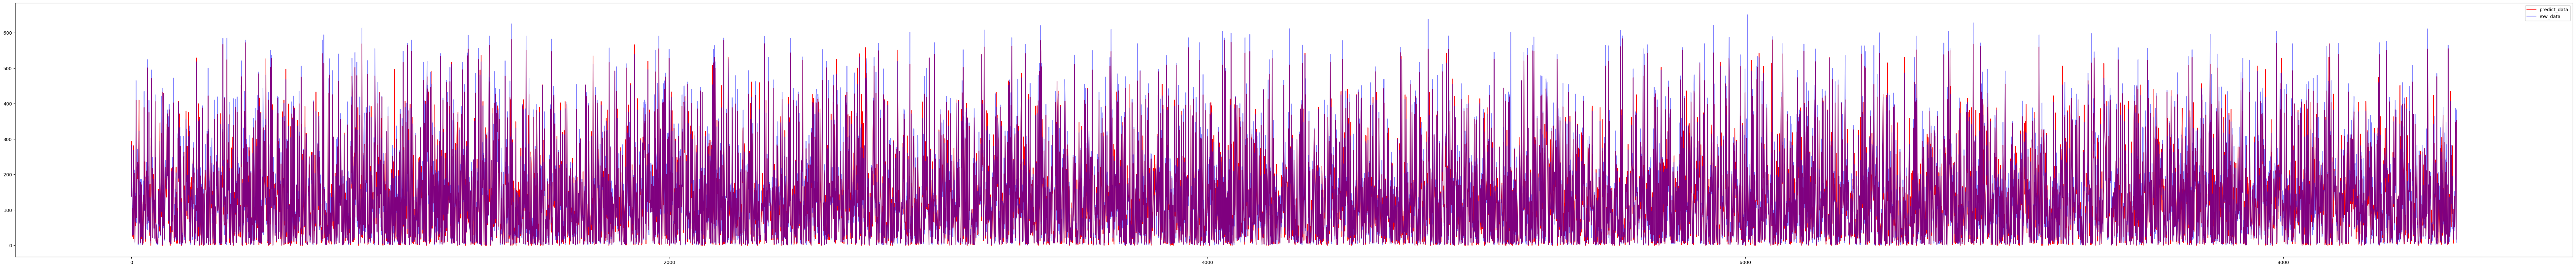

In [20]:
plt.figure(figsize=(100,10))
plt.plot(range(0,len(checked)),checked, color="r", label="predict_data")
plt.plot(range(0, len(x)), x, color="b", label="row_data", alpha=0.5)
plt.legend()
plt.show()

274/274 [==============================] - 1s 3ms/step


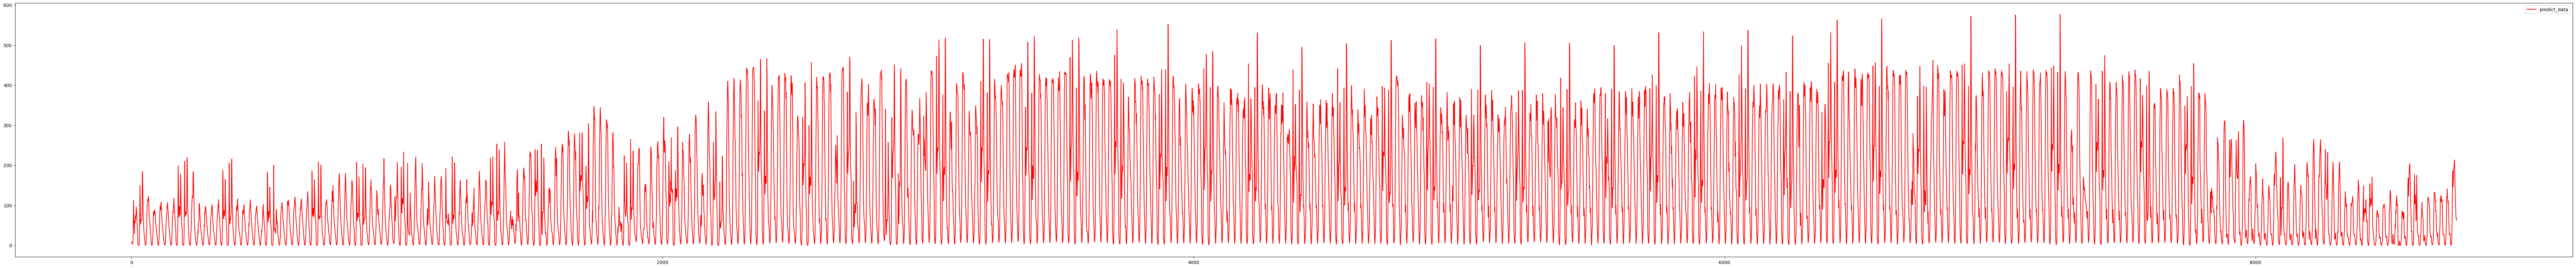

In [52]:
osaka_predicted = model.predict(osaka_y)
osaka_checked = np.array([check(i) for i in osaka_predicted]).reshape(osaka_predicted.shape[0],1)
plt.figure(figsize=(100,10))
plt.plot(range(0,len(osaka_checked)),osaka_checked, color="r", label="predict_data")
plt.legend()
plt.show()

In [51]:
osaka_data3 = np.hstack((osaka_data,osaka_checked))
np.savetxt("osaka_predicted.tsv",osaka_data3,delimiter="\t",fmt="%s")